In [28]:
import requests
import random as rd
import matplotlib.pyplot as plt
import numpy as np
from ortools.sat.python import cp_model


url = 'https://raw.githubusercontent.com/tamy0612/JSPLIB/master/instances.json'
response = requests.get(url)
pull = response.json()  # Parse the JSON

def instances_(i):
    if i > len(pull)-1:
        return print(f'Error: Please use a number less than {len(pull)}')
    else:
        url = f'https://raw.githubusercontent.com/tamy0612/JSPLIB/master/instances/{pull[i]["name"]}'
        response = requests.get(url)
        data = response.text # Parse the txt
        data = data.splitlines()[5:] # Dropping the first 5

        # Split each string into individual numbers and flatten the result
        flattened_data = [int(num) for line in data for num in line.split()]
        flattened_data = [(flattened_data[i], flattened_data[i+1]) for i in range(0, len(flattened_data)-1,2)]

        jobs = len(data)
        machines = int((len(flattened_data)/len(data)))

        # Convert to a 10x0y NumPy array
        instance = np.array(flattened_data).reshape(jobs, machines,2)
        instance = {i: {int(instance[i,j][0]): int(instance[i,j][1]) for j in range(machines)} for i in range(jobs)}
        return jobs, machines, instance

In [29]:
# Uncomment if running random job shop problem
# val = rd.randint(0,len(pull)-1)
val = 1

jobs, machines, instance = instances_(val)

In [30]:
instance

{0: {7: 62, 8: 24, 5: 25, 3: 84, 4: 47, 6: 38, 2: 82, 0: 93, 9: 24, 1: 66},
 1: {5: 47, 2: 97, 8: 92, 9: 22, 1: 93, 4: 29, 7: 56, 3: 80, 0: 78, 6: 67},
 2: {1: 45, 7: 46, 6: 22, 2: 26, 9: 38, 0: 69, 4: 40, 3: 33, 8: 75, 5: 96},
 3: {4: 85, 8: 76, 5: 68, 9: 88, 3: 36, 6: 75, 2: 56, 1: 35, 0: 77, 7: 85},
 4: {8: 60, 9: 20, 7: 25, 3: 63, 4: 81, 0: 52, 1: 30, 5: 98, 6: 54, 2: 86},
 5: {3: 87, 9: 73, 5: 51, 2: 95, 4: 65, 1: 86, 6: 22, 8: 58, 0: 80, 7: 65},
 6: {5: 81, 2: 53, 7: 57, 6: 71, 9: 81, 0: 43, 4: 26, 8: 54, 3: 58, 1: 69},
 7: {4: 20, 6: 86, 5: 21, 8: 79, 9: 62, 2: 34, 0: 27, 1: 81, 7: 30, 3: 46},
 8: {9: 68, 6: 66, 5: 98, 8: 86, 7: 66, 0: 56, 3: 82, 1: 95, 4: 47, 2: 78},
 9: {0: 30, 3: 50, 7: 34, 2: 58, 1: 77, 5: 34, 8: 84, 4: 40, 9: 46, 6: 44}}

#### **Mathematical Model**

#### Notation

1. Sets
- $i=a \in I$ $:$ set representing the number of jobs
- $j \in J$ $:$ set representing the number of machines
2. Variables
- $x_{ij}$ $:$ integer variable determining the start time of job $i$ on machine $j$
- $y_{ij}$ $:$ integer variable determining the end time of job $i$ on machine $j$
- $\delta_{ij,aj}$ $:$ binary variable that indicates whether or not job, machine combo $ij$ is ordered before combo $aj$.

 \begin{equation}
 \delta_{ij} =
   \left\{\begin{array}{lr}
       1, & \text{job $i$ on machine $j$ precedes job $a$ on machine $j$} \\
       0, & otherwise 
    \end{array}\right.
 \end{equation}
 
3. Parameters
- $instance_{ij}$ $:$ process times of job $i$, machine $j$ pairs 
- $M$ $:$ sufficiently large constant for the purposes of removing overlap

#### Formulation

1. **Objective** \
Our objective is to minimize the total makespan $C_{max}$, or the total duration of time needed to complete all jobs.
$$
\min C_{max} = \max_{ij}{(x_{ij} + y_{ij})}
$$

2. **Constraints**

\begin{align}
x_{ij} &\geq y_{aj} - M\delta_{ij,aj}  \quad & \forall i,j < a,j  \\
x_{aj} &\geq y_{ij} - M(1 - \delta_{ij,aj})  \quad & \forall i,j < a,j  \\
y_{ij} &\geq x_{i(j+1)} \quad & \forall i,j = \{1, \ldots J-1\} \\
x_{ij},y_{ij} &\geq 0 \quad & \forall i,j \\
x_{ij},y_{ij} &\in \mathbb{I} & \quad \forall i,j \\
\delta_{ij} &\in \{0,1\} \quad & \forall i,j < a,j 
\end{align}

- Constraints (1) and (2) ensure that no two jobs overlap one another on the same machine.
- Constraint (3) creates a job precedence wherein the end time of $y_{ij}$ must be before start time of $x_{i(j+1)}$.
- Constraint (4) and (5) ensures non-negativity and integer constraints for start and end times, respectively.
- Constraint (6) bounds $\delta$ to a binary variable.

#### Note:
OR-Tools has a built-in function that handles the non-overlap constraints shown in constraints (1),(2) and (6). Because of this, the code below won't entirely mimic the model above but will arrive at the same optimal solution. Nevertheless, I include the above as an exercise in model formulation and for future reference.

In [31]:
# Creates the model and set solver
model = cp_model.CpModel()
solver = cp_model.CpSolver()

horizon = sum(instance[i][j] for i in instance for j in instance[i])

# Variables

C = model.NewIntVar(0,horizon,'makespan')

x = {(i,j): model.NewIntVar(0,\
                         sum([instance[i][j] for i in instance for j in instance[i]]) - \
                            max([instance[i][j] for i in instance for j in instance[i]]),\
                                f'x_{i}_{j}') for i in instance for j in instance[i]}

y = {(i,j): model.NewIntVar(max([instance[i][j] for i in instance for j in instance[i]]),\
                         sum([instance[i][j] for i in instance for j in instance[i]]), \
                            f'y_{i}_{j}') for i in instance for j in instance[i]}

interval = {(i,j): model.NewIntervalVar(x[i,j], instance[i][j], y[i,j], f'interval_{i}_{j}') \
            for i in instance for j in instance[i]}

# No two jobs overlap times on the same machine
for j in range(machines):
   model.AddNoOverlap([interval[i,j] for i in instance])

# Job precedence: job i must be completed on machine j before starting on machine j+1
for i in range(jobs):
   lst = list(instance[i].keys())
   for j in range(len(lst)):
      if j+1 < len(lst):
         model.Add(y[i,lst[j]] <= x[i,lst[j+1]])

# Tracking the makespan
model.AddMaxEquality(C, [y[i,j] for i in instance for j in instance[i]])

model.Minimize(C)

status = solver.Solve(model)
print(f'Status = {solver.StatusName(status)}')

print(f'Makespan: {solver.value(C)} minutes.')

Status = OPTIMAL
Makespan: 978 minutes.


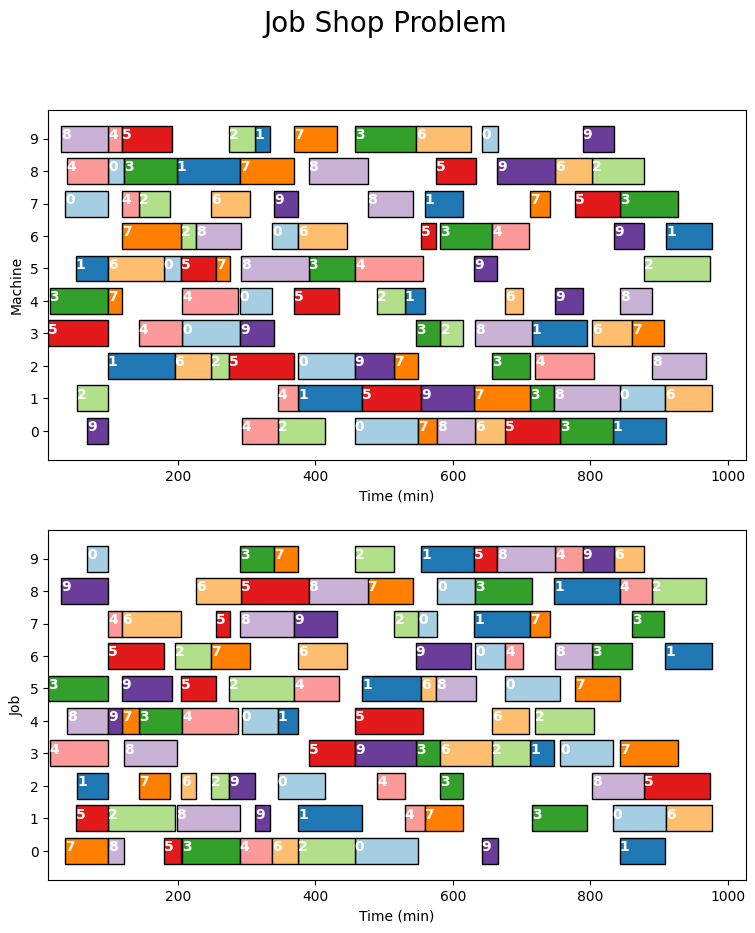

In [34]:
data = sorted([((i,j), (solver.value(x[i,j]),solver.value(y[i,j]))) \
               for i in instance for j in instance[i]], key = lambda k: [k[0][1], k[0][0]])
data2 = sorted(data, key= lambda k: [k[0][0]])

fig, ax = plt.subplots(2,1)
fig.suptitle('Job Shop Problem',fontsize = 20)

color = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

fig.set_figheight(max(jobs,machines))
fig.set_figwidth(max(jobs,machines)-1)

ax[0].barh(y = [str(data[i][0][1]) for i in range(len(data))], \
        left= [data[i][1][0] for i in range(len(data))], \
            width= [data[i][1][1] - data[i][1][0] for i in range(len(data))], color = color, edgecolor = 'k');

ax[1].barh(y = [str(data2[i][0][0]) for i in range(len(data2))], \
        left= [data2[i][1][0] for i in range(len(data2))], \
            width= [data2[i][1][1] - data2[i][1][0] for i in range(len(data2))], color = color, edgecolor = 'k');


for i in range(len(data)):
    ax[0].text(x=data[i][1][0], y=str(data[i][0][1]), s=str(data[i][0][0]), color = 'w', fontweight = 'bold')
    ax[1].text(x=data2[i][1][0], y=str(data2[i][0][0]), s=str(data2[i][0][1]), color = 'w', fontweight = 'bold')

ax[0].set_xlabel('Time (min)');
ax[0].set_ylabel('Machine');

ax[1].set_xlabel('Time (min)');
ax[1].set_ylabel('Job');